# Use Monte Carlo Reinforcement Learning to improve navigation

### We'll design a grid world and have an agent explore this space. The goal is to develop a policy that allows the agent to better navigate the grid world towards the goal state.
### User can customize the grid world by specifying the following parameters:
- height: grid world height (5 in this case)
- width: grid world width (5 in this case)
- taboo_states: locations of obstacles. These can be randomly generated, or user-defined (randomly generated 4 in this case)
- goal_state: the goal state the agent attempts to get to ((3,3) in this case)
- reward_goal: reward for reaching the goal state (+100pt in this case)
- reward_step: reward for taking a step that does not reach the goal state (-1pt in this case)

Below is an example of the grid world to be constructed. Each grid space is indexed as a tuple of (x, y).


<img src="Grid_world.png" alt="Drawing" style="width:300px; height:300px"/>

### Brief Context of Monte Carlo Reinforcement Learning Algorithms

Monte Carlo RL relies on the weak law of large numbers via random sampling to calculate estimates. Therefore, Monte Carlo RL algorithms are inherently computationally intensive. While they may not be a perfect fit for this grid example, I'm curious to examine the result from it. Monte Carlo RL algorithms also does not bootstrap since they each episode must be completed (marked by reaching the goal state in this case) before rewards can be calculated and policy updated.

The interaction between a reinforcement learning agent and the environment are illustrated in the figure below. Notice that the only feedback the agent receives from the environment is the reward and and state information. The agent receives no other evidence. 

<img src="RL_AgentModel.JPG" alt="Drawing" style="width:500px; height:300px"/>
<center> **Reinforcement Learning Agent and Environment** </center>  

### 1. Basic Setup Variables:

In [1]:
# Parameters for the grid world
width = 5
height = 5
goal_state = (3, 3)
num_taboo_states = 4
initial_state = (1, 1)

# Parameters for the reward incentives
reward_goal = 50
reward_step = -1

# Parameters for agent's exploration instructions (usually no need to change, the agent can explore a maximum of 4 cardinal direction)
index_action = {1:'u', 2:'d', 3:'l', 4:'r'} # (u = up, d = down, l = left, r = right)
action_index = {'u':0, 'd':1, 'l':2, 'r':3}

### 2. Set Up Grid World:
A. Generate taboo states

In [2]:
from itertools import product
from collections import defaultdict, Counter
import random

random.seed(99)

def generate_random_taboo_states(width,
                                 height,
                                 goal_state,
                                 num_taboo_states,
                                 initial_state = initial_state):
    states = list(product(range(1, width+1), range(1, height+1)))
    
    try:
        states.remove(goal_state)
        states.remove(initial_state)
    except Exception as e:
        print(f'Unable to remove goal_state {goal_state} from states! Is the goal_state in the states?')
        print(e)
        return False
    
    taboo_states = random.sample(states, num_taboo_states)

    return taboo_states
    
taboo_states = generate_random_taboo_states(width=width,
                                            height=height,
                                            goal_state=goal_state,
                                            num_taboo_states=num_taboo_states)
taboo_states

[(3, 5), (2, 3), (5, 2), (2, 2)]

### 2. Set Up Grid World:
B. Generate state transition map (a.k.a. neighbors)

In [3]:
def state_move_up(width,
                  height,
                  state,
                  goal_state,
                  taboo_states=[]):
    
    if state == goal_state:
        return goal_state
    x, y = state
    if y == height or (x, y+1) in taboo_states:
        return (x, y)
    else:
        return (x, y+1)

def state_move_down(width,
                    height,
                    state,
                    goal_state,
                    taboo_states=[]):
    
    if state == goal_state:
        return goal_state
    x, y = state
    if y == 1 or (x, y-1) in taboo_states:
        return (x, y)
    else:
        return (x, y-1)

def state_move_left(width,
                    height,
                    state,
                    goal_state,
                    taboo_states=[]):
    
    if state == goal_state:
        return goal_state
    x, y = state
    if x == 1 or (x-1, y) in taboo_states:
        return (x, y)
    else:
        return (x-1, y)
    
def state_move_right(width,
                     height,
                     state,
                     goal_state,
                     taboo_states=[]):
    
    if state == goal_state:
        return goal_state
    x, y = state
    if x == width or (x+1, y) in taboo_states:
        return (x, y)
    else:
        return (x+1, y)
    
def generate_neighbors(width,
                       height,
                       goal_state,
                       taboo_states=[],
                       delete_taboo_states=True):
    neighbors = {}
    
    for y in range(1, height+1):
        for x in range(1, width+1):
            state = (x,y)
            if delete_taboo_states:
                if state in taboo_states:
                    continue
            neighbors[state] = {'u': state_move_up(width,
                                                  height,
                                                  state,
                                                  goal_state,
                                                  taboo_states),
                               'd': state_move_down(width,
                                                    height,
                                                    state,
                                                    goal_state,
                                                    taboo_states),
                               'l': state_move_left(width,
                                                    height,
                                                    state,
                                                    goal_state,
                                                    taboo_states),
                               'r': state_move_right(width,
                                                     height,
                                                     state,
                                                     goal_state,
                                                     taboo_states)}
    return neighbors

neighbors = generate_neighbors(width=width,
                               height=height,
                               goal_state=goal_state,
                               taboo_states=taboo_states)

for state, state_actions in neighbors.items():
    print(f'{state}: {state_actions}')
        

(1, 1): {'u': (1, 2), 'd': (1, 1), 'l': (1, 1), 'r': (2, 1)}
(2, 1): {'u': (2, 1), 'd': (2, 1), 'l': (1, 1), 'r': (3, 1)}
(3, 1): {'u': (3, 2), 'd': (3, 1), 'l': (2, 1), 'r': (4, 1)}
(4, 1): {'u': (4, 2), 'd': (4, 1), 'l': (3, 1), 'r': (5, 1)}
(5, 1): {'u': (5, 1), 'd': (5, 1), 'l': (4, 1), 'r': (5, 1)}
(1, 2): {'u': (1, 3), 'd': (1, 1), 'l': (1, 2), 'r': (1, 2)}
(3, 2): {'u': (3, 3), 'd': (3, 1), 'l': (3, 2), 'r': (4, 2)}
(4, 2): {'u': (4, 3), 'd': (4, 1), 'l': (3, 2), 'r': (4, 2)}
(1, 3): {'u': (1, 4), 'd': (1, 2), 'l': (1, 3), 'r': (1, 3)}
(3, 3): {'u': (3, 3), 'd': (3, 3), 'l': (3, 3), 'r': (3, 3)}
(4, 3): {'u': (4, 4), 'd': (4, 2), 'l': (3, 3), 'r': (5, 3)}
(5, 3): {'u': (5, 4), 'd': (5, 3), 'l': (4, 3), 'r': (5, 3)}
(1, 4): {'u': (1, 5), 'd': (1, 3), 'l': (1, 4), 'r': (2, 4)}
(2, 4): {'u': (2, 5), 'd': (2, 4), 'l': (1, 4), 'r': (3, 4)}
(3, 4): {'u': (3, 4), 'd': (3, 3), 'l': (2, 4), 'r': (4, 4)}
(4, 4): {'u': (4, 5), 'd': (4, 3), 'l': (3, 4), 'r': (5, 4)}
(5, 4): {'u': (5, 5), 'd

### 2. Set Up Grid World:
C. Generate an initial uniform policy. This only includes legal moves (not colliding into walls or taboo states) to improve computation efficiency for the later Monte Carlo RL algorithms. This is because exclusion of illegal moves drastically reduces the steps needed to reach the goal state, so each start-to-end episode is shorter.

In [4]:
def generate_legal_policy(neighbors):
    """
    Generate uniform legal moves (evenly distribute move possibilities over legal moves).
    This will give a better starting policy for MC RL.
    """
    policy = {}
    
    for state, action_value in neighbors.items():
        legal_directions = []
        legal_moves = 0
        for action, next_state in action_value.items():
            if next_state != state:
                legal_moves += 1
                legal_directions.append(action)
            if legal_moves > 0:
                policy[state] = {}
            for move_direction in legal_directions:
                policy[state][move_direction] = float(1/legal_moves)

    return policy

uniform_legal_policy = generate_legal_policy(neighbors)

uniform_legal_policy

{(1, 1): {'u': 0.5, 'r': 0.5},
 (2, 1): {'l': 0.5, 'r': 0.5},
 (3, 1): {'u': 0.3333333333333333,
  'l': 0.3333333333333333,
  'r': 0.3333333333333333},
 (4, 1): {'u': 0.3333333333333333,
  'l': 0.3333333333333333,
  'r': 0.3333333333333333},
 (5, 1): {'l': 1.0},
 (1, 2): {'u': 0.5, 'd': 0.5},
 (3, 2): {'u': 0.3333333333333333,
  'd': 0.3333333333333333,
  'r': 0.3333333333333333},
 (4, 2): {'u': 0.3333333333333333,
  'd': 0.3333333333333333,
  'l': 0.3333333333333333},
 (1, 3): {'u': 0.5, 'd': 0.5},
 (4, 3): {'u': 0.25, 'd': 0.25, 'l': 0.25, 'r': 0.25},
 (5, 3): {'u': 0.5, 'l': 0.5},
 (1, 4): {'u': 0.3333333333333333,
  'd': 0.3333333333333333,
  'r': 0.3333333333333333},
 (2, 4): {'u': 0.3333333333333333,
  'l': 0.3333333333333333,
  'r': 0.3333333333333333},
 (3, 4): {'d': 0.3333333333333333,
  'l': 0.3333333333333333,
  'r': 0.3333333333333333},
 (4, 4): {'u': 0.25, 'd': 0.25, 'l': 0.25, 'r': 0.25},
 (5, 4): {'u': 0.3333333333333333,
  'd': 0.3333333333333333,
  'l': 0.3333333333333

In [5]:
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
%matplotlib inline

def get_size_from_neighbors(neighbors):
    width, height = list(neighbors.keys())[-1]
    return width, height


def policy_arrow(policy,
                 arrow_start_offset=0.1,
                 length_multiplier=0.25):
    """This function is for all states"""
    arrow_start_end_list = []
    for state, action_probs in policy.items():
        for action, prob in action_probs.items():             
            if action == 'u':
                arrow_start_x = state[0] - 0.5
                arrow_start_y = state[1] - 0.5 + arrow_start_offset
                arrow_end_x = 0
                arrow_end_y = prob * length_multiplier

            elif action == 'd':
                arrow_start_x = state[0] - 0.5
                arrow_start_y = state[1] - 0.5 - arrow_start_offset
                arrow_end_x = 0
                arrow_end_y = -prob * length_multiplier

            elif action == 'l':
                arrow_start_x = state[0] - 0.5 - arrow_start_offset
                arrow_start_y = state[1] - 0.5
                arrow_end_x = -prob * length_multiplier
                arrow_end_y = 0

            elif action == 'r':
                arrow_start_x = state[0] - 0.5 + arrow_start_offset
                arrow_start_y = state[1] - 0.5
                arrow_end_x = prob * length_multiplier
                arrow_end_y = 0
                    
            arrow_start_end = [arrow_start_x,
                               arrow_start_y,
                               arrow_end_x,
                               arrow_end_y]
            
            arrow_start_end_list.append(arrow_start_end)
    
    return arrow_start_end_list


def plot_policy(neighbors,
                policy,
                goal_state,
                taboo_states,
                plot_title=None,
                plot_fig_size=(8,8),
                plot_arrows=True,
                font_size=20,
                cell_width=1,
                cell_height=1,
                arrow_start_offset=0.1,
                length_multiplier=0.25,
                arrow_width=0.03):
    
    width, height = get_size_from_neighbors(neighbors)
    
    fig = plt.figure(figsize=plot_fig_size)
    if not plot_title:
        plot_title = 'Maze w/ Policy'
    plt.title(plot_title, fontdict={'fontsize': font_size})
    ax = fig.gca()
    
    # Draw grid for the grid world
    for indx in range(width+1):
        x = cell_width * indx
        ax.plot([x, x], [0.0, height], linestyle='solid', color='k')
        
    for indy in range(height+1):
        y = cell_height * indy
        ax.plot([0, width], [y, y], linestyle='solid', color='k')

    # plot goal state
    goal_state_x, goal_state_y = goal_state
    goal_state_x_plt_pos = (goal_state_x - 1) * cell_width
    goal_state_y_plt_pos = (goal_state_y - 1) * cell_height
    goal_box = Rectangle((goal_state_x_plt_pos, goal_state_y_plt_pos),
                          width=cell_width,
                          height=cell_height,
                          fill=True)
    goal_pc = PatchCollection([goal_box],
                              facecolor='g',
                              alpha=0.5,
                              edgecolor='g')
    ax.text(x = goal_state_x_plt_pos + cell_width * 0.5,
            y = goal_state_y_plt_pos + cell_height * 0.5,
            s = 'Goal',
            ha = 'center',
            va = 'center',
            fontdict = {'fontsize': font_size})
    
    ax.add_collection(goal_pc)
    
    # plot taboo_states
    taboo_boxes = []
    for taboo_state in taboo_states:
        taboo_state_x_plt_pos = (taboo_state[0] - 1) * cell_width
        taboo_state_y_plt_pos = (taboo_state[1] - 1) * cell_height
        taboo_box = Rectangle((taboo_state_x_plt_pos, taboo_state_y_plt_pos),
                              width=cell_width,
                              height=cell_height,
                              fill=True)
        taboo_boxes.append(taboo_box)
        
        ax.text(x = taboo_state_x_plt_pos + cell_width * 0.5,
                y = taboo_state_y_plt_pos + cell_height * 0.5,
                s = 'Taboo',
                ha = 'center',
                va = 'center',
                fontdict = {'fontsize': font_size})

    taboo_pc = PatchCollection(taboo_boxes,
                               facecolor='r',
                               alpha=0.5,
                               edgecolor='r')
    ax.add_collection(taboo_pc)
    
    # plot arrows for each state
    # set the origins of arrows at the center of each box
    if plot_arrows:
        arrow_start_end_list = policy_arrow(policy=policy,
                                            arrow_start_offset=arrow_start_offset,
                                            length_multiplier=length_multiplier)

        for arrow in arrow_start_end_list:
            ax.arrow(arrow[0], arrow[1], arrow[2], arrow[3], width=arrow_width, color='b')

    plt.show()



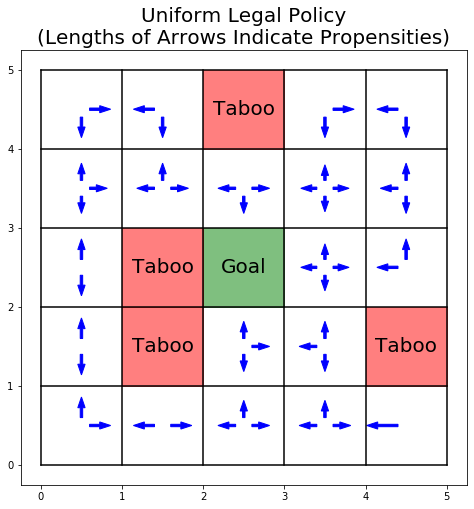

In [6]:
plot_policy(neighbors=neighbors,
            policy=uniform_legal_policy,
            goal_state=goal_state,
            taboo_states=taboo_states,
            plot_title='Uniform Legal Policy\n(Lengths of Arrows Indicate Propensities)',
            cell_width=1,
            cell_height=1)

### 2. Set Up Grid World:
D. generate reward incentives for the agent

In [7]:
def generate_rewards(neighbors,
                     goal_state,
                     reward_goal=reward_goal,
                     reward_step=reward_step):
    rewards = {}
    
    for state, action_states in neighbors.items():
        if state == goal_state:
            continue
        rewards[state] = {}
        for action, next_state in action_states.items():
            if next_state == goal_state:
                rewards[state][action] = reward_goal
            else:
                rewards[state][action] = reward_step
    
    return rewards

rewards = generate_rewards(neighbors=neighbors,
                           goal_state=goal_state,
                           reward_goal=reward_goal,
                           reward_step=reward_step)

rewards

{(1, 1): {'u': -1, 'd': -1, 'l': -1, 'r': -1},
 (2, 1): {'u': -1, 'd': -1, 'l': -1, 'r': -1},
 (3, 1): {'u': -1, 'd': -1, 'l': -1, 'r': -1},
 (4, 1): {'u': -1, 'd': -1, 'l': -1, 'r': -1},
 (5, 1): {'u': -1, 'd': -1, 'l': -1, 'r': -1},
 (1, 2): {'u': -1, 'd': -1, 'l': -1, 'r': -1},
 (3, 2): {'u': 50, 'd': -1, 'l': -1, 'r': -1},
 (4, 2): {'u': -1, 'd': -1, 'l': -1, 'r': -1},
 (1, 3): {'u': -1, 'd': -1, 'l': -1, 'r': -1},
 (4, 3): {'u': -1, 'd': -1, 'l': 50, 'r': -1},
 (5, 3): {'u': -1, 'd': -1, 'l': -1, 'r': -1},
 (1, 4): {'u': -1, 'd': -1, 'l': -1, 'r': -1},
 (2, 4): {'u': -1, 'd': -1, 'l': -1, 'r': -1},
 (3, 4): {'u': -1, 'd': 50, 'l': -1, 'r': -1},
 (4, 4): {'u': -1, 'd': -1, 'l': -1, 'r': -1},
 (5, 4): {'u': -1, 'd': -1, 'l': -1, 'r': -1},
 (1, 5): {'u': -1, 'd': -1, 'l': -1, 'r': -1},
 (2, 5): {'u': -1, 'd': -1, 'l': -1, 'r': -1},
 (4, 5): {'u': -1, 'd': -1, 'l': -1, 'r': -1},
 (5, 5): {'u': -1, 'd': -1, 'l': -1, 'r': -1}}

### 3. Explore the Grid World:
A. Simulate environment for the agent for a single baby step

In [8]:
def simulate_environment(s,
                         action, 
                         neighbors = neighbors,
                         rewards = rewards,
                         goal_state = goal_state):
    """
    Function simulates the environment
    returns s_prime and reward given s and action
    """
    s_prime = neighbors[s][action]
    reward = rewards[s][action]
    return (s_prime, reward, is_goal_state(s_prime, goal_state))

def is_goal_state(state,
                  goal_state = goal_state):
    return state == goal_state

## Test the function
example_starting_state = random.sample(list(neighbors.keys()), 1)[0]
print(f'example_starting_state: {example_starting_state}')

for a in ['u', 'd', 'r', 'l']:
    print(simulate_environment(s = example_starting_state,
                               action = a))

example_starting_state: (4, 2)
((4, 3), -1, False)
((4, 1), -1, False)
((4, 2), -1, False)
((3, 2), -1, False)


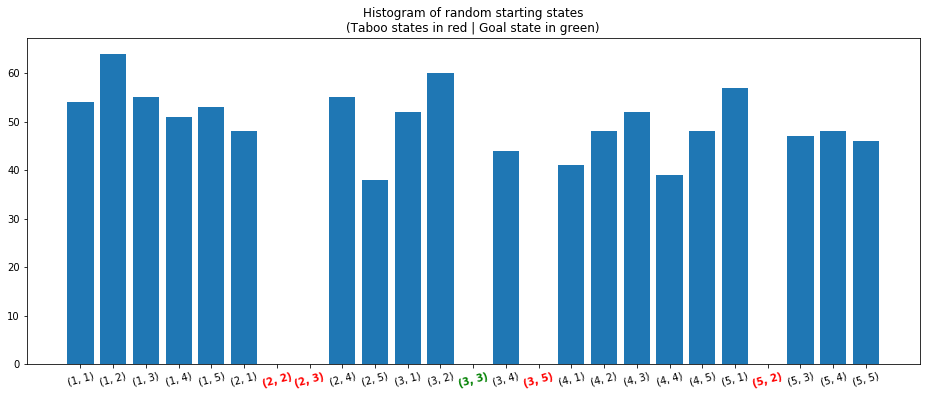

In [9]:
def start_episode(neighbors,
                  taboo_states = taboo_states,
                  goal_state = goal_state):
    '''Function to find a random starting value for the episode
    that is not the terminal state'''
    states = list(neighbors.keys())
    state = random.sample(states, 1)[0]
    while (state == goal_state) or (state in taboo_states):
         state = random.sample(states, 1)[0]
    return state

## test the function to make sure never starting in the goal state or taboo states
sample_start_states = Counter([start_episode(neighbors) for _ in range(1000)])

complete_states = defaultdict(int)
for x in range(1, width + 1):
    for y in range(1, height + 1):
        complete_states[(x, y)] = sample_start_states[(x, y)]

taboo_indexes = []

sorted_states = sorted(list(complete_states.keys()))

for index, state in enumerate(sorted_states):
    if state in taboo_states:
        taboo_indexes.append(index)
    if state == goal_state:
        goal_index = index
        
plt.figure(figsize=(16,6))
plt.title(f'Histogram of random starting states\n(Taboo states in red | Goal state in green)')
plt.bar(list(map(str, sorted(list(complete_states.keys())))), list(complete_states.values()))
for taboo_index in taboo_indexes:
    plt.gca().get_xticklabels()[taboo_index].set_color('r')
    plt.gca().get_xticklabels()[taboo_index].set_fontweight('bold')
plt.gca().get_xticklabels()[goal_index].set_color('g')
plt.gca().get_xticklabels()[goal_index].set_fontweight('bold')

plt.xticks(rotation=15)
plt.show()

Looks like the random starting states nicely avoid the taboo states & goal state. This is a desired behavior.

In [10]:
import numpy.random as nr

def take_action(state,
                policy,
                index_actions = index_action):
    '''
    Function takes action given state using the transition probabilities of the policy
    '''
    ## Find the action given the transistion probabilities defined by the policy.
    action = nr.choice(list(policy[state].keys()), p = list(policy[state].values()))
    s_prime, reward, is_goal_state = simulate_environment(state, action)
    
    return action, s_prime, reward, is_goal_state

## Test function for several states
for state in [start_episode(neighbors) for _ in range(10)]:
    print(take_action(state,
                      policy = uniform_legal_policy))

('u', (4, 2), -1, False)
('u', (1, 3), -1, False)
('l', (1, 5), -1, False)
('l', (1, 1), -1, False)
('d', (3, 1), -1, False)
('r', (2, 4), -1, False)
('l', (4, 3), -1, False)
('l', (3, 3), 50, True)
('d', (1, 1), -1, False)
('d', (4, 3), -1, False)


### 3. Explore the Grid World:
B. Chaining together baby steps into a complete episode (from starting state to goal state)

In [11]:
import numpy as np
from tqdm import tqdm_notebook

def MC_episode(policy,
               G,
               n_visits,
               episode,
               width,
               neighbors = neighbors,
               taboo_states = taboo_states,
               goal_state = goal_state): 
    '''
    Function creates the Monte Carlo samples of one episode.
    This function does most of the real MC RL work.
    '''
    ## For each episode we use a list to keep track of states we have visited.
    ## Once we visit a state we need to accumulate values to get the returns
    states_visited = []
    states = list(policy.keys())
    
    ## Find the starting state
    current_state = start_episode(neighbors=neighbors,
                                  taboo_states=taboo_states,
                                  goal_state=goal_state)

    is_goal_state = False
    g = 0.0
        
    while (not is_goal_state):
        ## Find the next action and reward
        action, s_prime, reward, is_goal_state = take_action(current_state, policy)
        
        ## Add the reward to the states visited if this is a first visit  
        if(current_state not in states_visited):
            ## Mark that the current state has been visited 
            states_visited.append(current_state) 
            ## Add the reward to states visited 
            for state in states_visited:
                state_1d_index = state[0] - 1 + (state[1] - 1) * width
                n_visits[state_1d_index] = n_visits[state_1d_index] + 1
                G[state_1d_index] = G[state_1d_index] + (reward - G[state_1d_index])/n_visits[state_1d_index]
        
        ## Update the current state for next transition
        current_state = s_prime
        
    return G, n_visits

### 3. Explore the Grid World:
C. Calculate state values based on random sampling of many episodes

In [12]:
def MC_state_values(policy=uniform_legal_policy,
                    neighbors=neighbors,
                    taboo_states=taboo_states,
                    goal_state=goal_state,
                    n_episodes=10):
    '''
    Function that evaluates the state value of a policy using the Monte Carlo method.
    '''
    # Create list of states 
    states = list(policy.keys())
    n_states = len(states)
    
    # get neighbors width
    width, height = get_size_from_neighbors(neighbors)
    num_cells = width * height
    
    # An array to hold the accumulated returns as we visit states
    G = np.zeros((num_cells))
    
    ## An array to keep track of how many times we visit each state so we can 
    ## compute the mean
    n_visits = np.zeros((num_cells))
    
    prog_bar = tqdm_notebook(total=n_episodes)
    prog_bar.set_description_str('Iterating over MC episodes')
    
    ## Iterate over the episodes
    for i in range(n_episodes):
        G, n_visits = MC_episode(policy,
                                 G,
                                 n_visits,
                                 i,
                                 width,
                                 neighbors,
                                 taboo_states,
                                 goal_state)
        prog_bar.update(1)
    
    prog_bar.close()
    
    return np.flipud(G.reshape((height, width)))
        

## Test the functions
nr.seed(0)
state_values = MC_state_values(policy=uniform_legal_policy,
                               neighbors=neighbors,
                               taboo_states=taboo_states,
                               goal_state=goal_state,
                               n_episodes=1000)

print(np.round(state_values, 2))


[[2.16 2.11 0.   2.19 2.29]
 [1.94 2.31 4.82 2.23 1.92]
 [1.92 0.   0.   3.99 1.99]
 [2.02 0.   5.96 2.98 0.  ]
 [2.15 2.24 2.68 2.51 2.84]]


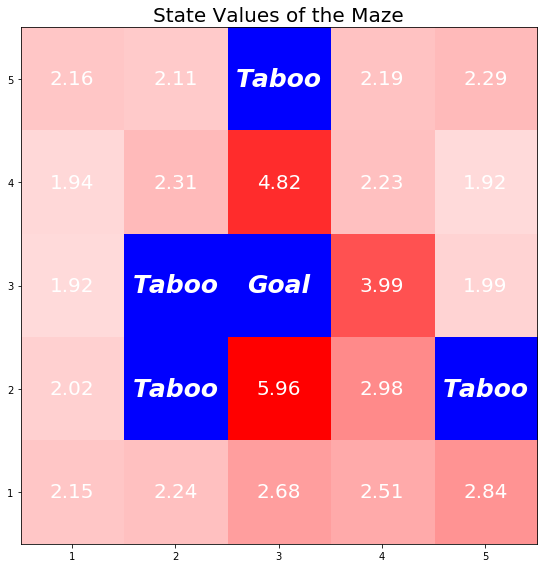

In [13]:
def plot_state_values(state_values,
                      plot_fig_size=(8,8),
                      log_offset = .1,
                      taboo_states=taboo_states,
                      goal_state=goal_state,
                      width=width,
                      height=height,
                      title_font_size=20,
                      cmap='bwr',
                      text_color='w',
                      text_font_size=20,
                      interpolation='nearest'):
    log_state_values = np.log(state_values + log_offset)
    
    fig, ax = plt.subplots()
    fig.set_figwidth(plot_fig_size[0])
    fig.set_figheight(plot_fig_size[1])
    ax.set_xticks(np.arange(width + 1))
    ax.set_yticks(np.arange(height + 1)) # reverse the y label to match the defined grid world
    ax.set_xticklabels(range(1, width + 1))
    ax.set_yticklabels(range(1, height + 1)[::-1])
    
    im = ax.imshow(log_state_values, cmap='bwr', interpolation='nearest')
    
    # Construct an array for text display
    state_values_str_arr = np.round(state_values, 2).astype('str')
    for taboo_state in taboo_states:
        state_values_str_arr[height - taboo_state[1]][taboo_state[0] - 1] = 'Taboo'
    state_values_str_arr[height - goal_state[1]][goal_state[0] - 1] = 'Goal'
    
    for x in range(width):
        for y in range(height):
            if state_values_str_arr[x, y] == 'Goal' or state_values_str_arr[x, y] == 'Taboo':
                text = ax.text(y,
                               x,
                               state_values_str_arr[x, y],
                               ha='center',
                               va='center',
                               fontsize=text_font_size + 5,
                               color=text_color,
                               fontweight='bold',
                               fontstyle='italic')
            else:
                text = ax.text(y,
                               x,
                               state_values_str_arr[x, y],
                               ha='center',
                               va='center',
                               fontsize=text_font_size,
                               color=text_color)
        
    ax.set_title('State Values of the Maze', fontsize=title_font_size)
    fig.tight_layout()
    plt.show()
    
plot_state_values(state_values,
                  log_offset=0.8,
                  plot_fig_size=(8,8))

W/ the uniform legal policy, we can see that state values generally increase as the state is closer to the goal state. We can use these state values to improve the existing uniform, indiscriminate policy.

### 4. Policy Improvement:
A. Improve the initial uniform, indiscriminate policy based on the calculated state values.

In [14]:
nr.seed(100)

def MC_action_value_episode(policy,
                            Q,
                            n_visits,
                            initial_state,
                            width,
                            height,
                            action_index = action_index):
    '''
    Function creates the Monte Carlo samples of action values for one episode.
    '''
    ## For each episode we use a list to keep track of states we have visited.
    ## Once we visit a state we need to accumulate values to get the returns
    num_cells = width * height
    n_actions = len(action_index)
    
    state_actions_visited = np.zeros((num_cells, n_actions))
    
    current_state = initial_state
    is_goal_state = False
    
    while (not is_goal_state):
        ## Find the next action and reward
        action, s_prime, reward, is_goal_state = take_action(current_state, policy)
        
        action_idx = action_index[action]
        
        state_1d_index = current_state[0] - 1 + (current_state[1] - 1) * width
        
        ## Check if this state-action has been visited.
        if(state_actions_visited[state_1d_index, action_idx] != 1.0):
            ## Mark that the current state-action has been visited 
            state_actions_visited[state_1d_index, action_idx] = 1.0  
            ## This is first vist MS, so must loop over all state-action pairs and 
            ## add the reward and increment the count for the ones visited.
            for s,a in list(product(range(num_cells), range(n_actions))):
                ## Add reward to if these has been a visit to the state
                if(state_actions_visited[s,a] == 1.0):
                    n_visits[s,a] = n_visits[s,a] + 1.0
                    Q[s,a] = Q[s,a] + (reward - Q[s,a])/n_visits[s,a]    
        ## Update the current state for next transition
        current_state = s_prime
        
    return Q, n_visits

## Basic test of the function
Q = np.zeros((width * height, len(action_index)))
n_visits = np.zeros((width * height, len(action_index)))

Q, n_visits = MC_action_value_episode(policy=uniform_legal_policy,
                                      Q=Q,
                                      n_visits=n_visits,
                                      initial_state=initial_state,
                                      width=width,
                                      height=height)
print('Q')
print(np.round(Q, 3))
print('\nn_visits')
print(n_visits)

Q
[[ 5.375  0.     0.     4.1  ]
 [ 0.     0.     4.667  0.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [ 7.5    6.286  0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [11.75   9.2    0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.    16.   ]
 [ 0.     0.     0.    24.5  ]
 [ 0.    50.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]]

n_visits
[[ 8.  0.  0. 10.]
 [ 0.  0.  9.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 6.  7.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 4.  5.  0.  0.]
 [ 

In [15]:
import pandas as pd

def MC_action_values(policy,
                     Q,
                     width,
                     height,
                     n_episodes,
                     initial_state,
                     action_index=action_index):
    '''
    Function evaluates the action-values given a policy for the specified number of episodes and initial state
    '''
    
    n_states = width * height
    n_actions = len(action_index)
    ## Array to count visits to action-value pairs
    n_visits = np.zeros((n_states, n_actions))
    ## Dictionary to hold neighbor states
    neighbors = {}
    
    prog_bar = tqdm_notebook(total = n_episodes)
    prog_bar.set_description_str(f'Iterating over {n_episodes} MC action state episodes...')
    ## Loop over number of episodes
    for _ in range(n_episodes):
        ## One episode of MC
        Q, n_visits = MC_action_value_episode(policy,
                                              Q,
                                              n_visits,
                                              initial_state,
                                              width,
                                              height,
                                              action_index)
        prog_bar.update(1)
    
    prog_bar.close()
    return(Q)

def pandify_Q(Q,
              columns = ['up', 'down', 'left', 'right']):
    Q = pd.DataFrame(Q, columns = columns)
    
    return Q

## Basic test of the function
n_episodes = 10000
Q = np.zeros((width * height, len(action_index)))

Q = MC_action_values(policy=uniform_legal_policy,
                     Q=Q,
                     width=width,
                     height=height,
                     action_index=action_index,
                     n_episodes=n_episodes,
                     initial_state=initial_state)
Q_df = pandify_Q(Q)
Q_df

,up,down,left,right
0,1.966517,0.000000,0.000000,2.404922
1,0.000000,0.000000,2.482354,3.167493
2,5.454148,0.000000,3.187642,3.418202
3,4.462332,0.000000,4.206728,3.748156
4,0.000000,0.000000,4.235596,0.000000
5,2.131852,2.445792,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000
7,50.000000,4.246005,0.000000,4.465012
8,5.013358,4.206770,6.219046,0.000000
9,0.000000,0.000000,0.000000,0.000000


In [16]:
from copy import deepcopy

def update_policy(policy,
                  Q=Q,
                  epsilon=0.1,
                  width=width,
                  height=height,
                  action_index=action_index,
                  debug=False):
    '''
    Updates the policy based on estiamtes of Q using an epslion greedy algorithm. The action with the highest 
    action value is used.
    '''
    avail_states = sorted(list(policy.keys()))
    ## Find the keys for the actions in the policy
    print(f'\n Q:\n{Q}')
    ## Iterate over the states and find the maximm action value.
    for state_2d_index in avail_states:
        # First find the index of the max Q values

        state_1d_index = (state_2d_index[1] - 1) * width + state_2d_index[0] - 1
        q = Q[state_1d_index,:]
        no_zero_q = deepcopy(q)
        np.place(no_zero_q, no_zero_q == 0, float("-inf"))
        max_action_index = np.where(no_zero_q == max(no_zero_q))[0]

        # Find the probabilities for the transitions
        n_transitions = len(policy[state_2d_index])
        n_max_transitions = min(len(max_action_index), n_transitions)
        p_max_transitions = (1.0 - epsilon * (n_transitions - n_max_transitions)) / (n_max_transitions)
        if debug:
            print(f'state_2d_index: {state_2d_index} | state_1d_index: {state_1d_index}')
            print(f'state: {state_1d_index} - q:{q}')
            print(f'n_transitions: {n_transitions} | n_max_transitions: {n_max_transitions} | p_max_transitions: {p_max_transitions}')
        keys = policy[state_2d_index].keys()
        ## Now assign the probabilities to the policy as epsilon greedy.
        for key in keys:
            if(action_index[key] in max_action_index):
                policy[state_2d_index][key] = p_max_transitions
            else:
                policy[state_2d_index][key] = epsilon

    return policy            

wip_legal_policy = deepcopy(uniform_legal_policy)

update_policy(policy=wip_legal_policy,
              Q=Q,
              epsilon=0.1,
              width=width,
              height=height,
              action_index=action_index)


 Q:
[[ 1.9665165   0.          0.          2.40492239]
 [ 0.          0.          2.48235429  3.16749308]
 [ 5.45414786  0.          3.18764221  3.41820206]
 [ 4.46233188  0.          4.20672824  3.74815585]
 [ 0.          0.          4.23559553  0.        ]
 [ 2.13185155  2.44579198  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [50.          4.24600468  0.          4.46501178]
 [ 5.01335843  4.20677025  6.21904627  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 2.38408279  2.58494639  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 4.20997807  5.08644828 50.          4.32329945]
 [ 4.18211896  0.          6.2906592   0.        ]
 [ 2.73180601  2.917544    0.          3.26399076]
 [ 3.30666011  0.          3.27169729  5.34575522]
 [ 0.         50.          4.16280472  3.93541456]
 [ 3.82398213  5.86365876  6.181693    3.9744673 ]
 [ 4.12038561  4.90905484 

{(1, 1): {'u': 0.1, 'r': 0.9},
 (2, 1): {'l': 0.1, 'r': 0.9},
 (3, 1): {'u': 0.8, 'l': 0.1, 'r': 0.1},
 (4, 1): {'u': 0.8, 'l': 0.1, 'r': 0.1},
 (5, 1): {'l': 1.0},
 (1, 2): {'u': 0.1, 'd': 0.9},
 (3, 2): {'u': 0.8, 'd': 0.1, 'r': 0.1},
 (4, 2): {'u': 0.1, 'd': 0.1, 'l': 0.8},
 (1, 3): {'u': 0.1, 'd': 0.9},
 (4, 3): {'u': 0.1, 'd': 0.1, 'l': 0.7, 'r': 0.1},
 (5, 3): {'u': 0.1, 'l': 0.9},
 (1, 4): {'u': 0.1, 'd': 0.1, 'r': 0.8},
 (2, 4): {'u': 0.1, 'l': 0.1, 'r': 0.8},
 (3, 4): {'d': 0.8, 'l': 0.1, 'r': 0.1},
 (4, 4): {'u': 0.1, 'd': 0.1, 'l': 0.7, 'r': 0.1},
 (5, 4): {'u': 0.1, 'd': 0.8, 'l': 0.1},
 (1, 5): {'d': 0.9, 'r': 0.1},
 (2, 5): {'d': 0.9, 'l': 0.1},
 (4, 5): {'d': 0.9, 'r': 0.1},
 (5, 5): {'d': 0.9, 'l': 0.1}}

### 5. Visualize the Result
A. Compare the initial uniform policy and improved policy

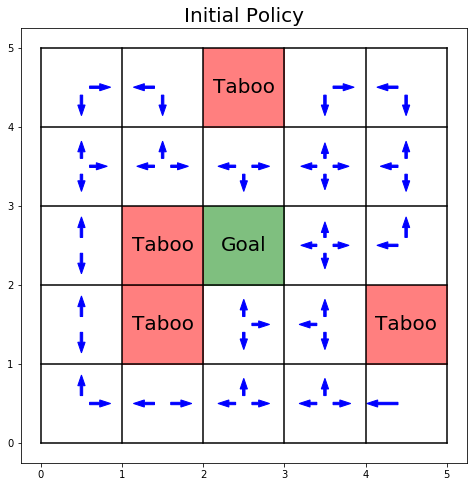

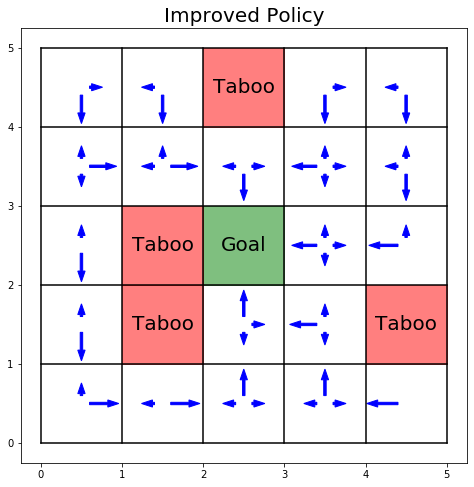

In [17]:
plot_policy(neighbors=neighbors,
            policy=uniform_legal_policy,
            goal_state=goal_state,
            taboo_states=taboo_states,
            plot_title='Initial Policy',
            cell_width=1,
            cell_height=1)

plot_policy(neighbors=neighbors,
            policy=wip_legal_policy,
            goal_state=goal_state,
            taboo_states=taboo_states,
            plot_title='Improved Policy',
            cell_width=1,
            cell_height=1)

### Looks like the improved policy can indeed much better guide the agent intelligently towards the goal state! 

Note that from state (1, 3), the agent apparently prefers to take the slightly longer route via state (1, 2). This makes sense for the agent, since this slightly longer route involves far fewer "branching" (due to taboo states & walls) while meandering towards the goal. In other words, in the case of Monte Carlo random sampling, this slightly longer route is far more "certain" to achieve the goal state quickly, therefore preferred.

**Or put it differently, the certainty of a narrow mountain pass leading towards the destination is preferrable to meadering on a vast plain, hoping to blindly stumble upon the destination. Wouldn't a human, w/o the knowlegde of a local map, do exactly the same?**

The fact I've limited agent's possible actions to only legal (non-colliding) moves contributes to this apparent oddity to a degree, since the agent "is not allowed to drift off the mountain pass".